## Cluster Segmentation

<a id='intro'></a>
### I. Introduction

Our charity is approaching the established budget limit for the fiscal year prematurely due to several expected donations failing to come through during the last quarter. This has lead to an unsustainable overhead and debt that is currently insurmountable. If something drastic is not done, and soon, our organization will face dissolution. Donor acquisition is both time consuming and costly. There are limited resources that must be allocated to find and contact potential donors. Given this situation, two methods will be utilized to find the best approach.

The first method will be to use a Logistic Regression model with supervised learning. Our charity has an existing donor network, from which we can train a model to discern who is likely to donate in the future, even on unseen data points. Historically, donors to our charity have had a salary that is greater than $50,000/year. The model will be tested against a secondary, potential donor network dataset to gauge its effectiveness during our upcoming outreach.

The second method will be through the lense of unsupervised learning: Principal Component Analysis decomposition in conjunction with a KMeans Clustering segmentation algorithm to find natural donor striation within the existing network. These learned clusters may then be used to parse the secondary, potential donor network dataset to find likely contributors to our charity.

Lastly, these two methods may be ensembled together to find the intersection of those individuals which our first model predicts is likely to donate and those who are labeled as a part of our top contributing cluster by the second model.

### Table of Contents
- [I. Introduction](#intro)
- [II. Explore & Transform](#explore)
- [III. Supervised Predictive Modeling](#supervised)
- [IV. Unsupervised Clustering Segmentation](#unsupervised)
- [V. Intersecting Prediction & Segmentation](#intersecting)
- [VI. Final Thoughts](#final)
- [VII. Sources](#sources)

### Import

In [1]:
# bring key libraries and functionality into the notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, fbeta_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

### Load

First, we will load in the existing and potential donor network datasets. Several thousand duplicates were discovered in the existing donor network dataset during the initial exploration off-screen, and are discarded here. Specific columns have been chosen based on the commonality between the two datasets, with the others that are unique to each being left in the original csv files. Although both datasets contain additional columns, comparing them appropriately requires precise similarity. Columns that contain the same kind of data but use different naming conventions across the two datasets are adjusted and renamed accordingly. A sample of rows from both are shown to get an idea of what we are working with. It will be seen that the column values themselves vary dramatically, which will require additional cleaning for them to be pliable. 

In [2]:
# read in existing donor network data
original_existing_donors = pd.read_csv('existing_donors_data.csv')

# drop duplicate rows from dataset
original_existing_donors.drop_duplicates(inplace=True)

# only invoke with columns that are relavent to project
df1 = original_existing_donors[['age', 'education_level', 'marital-status',
                                'sex', 'income']].copy(deep=True)

# adjust names for consistency across datasets
df1.rename(columns={'marital-status' : 'marital_status',
                    'sex': 'gender'}, inplace=True)
# show a few rows
df1.head()

,age,education_level,marital_status,gender,income
0,39,Bachelors,Never-married,Male,<=50K
1,50,Bachelors,Married-civ-spouse,Male,<=50K
2,38,HS-grad,Divorced,Male,<=50K
3,53,11th,Married-civ-spouse,Male,<=50K
4,28,Bachelors,Married-civ-spouse,Female,<=50K


In [3]:
# read in potential donor network data
original_potential_donors = pd.read_csv('potential_donors_data.csv')

# only invoke with columns that are relavent to project
df2 = original_potential_donors[['Age', 'Education Level', 'Marital Status',  
                                 'Gender', 'Income Level']].copy(deep=True)

# adjust names for consistency across datasets
df2.rename(columns={'Age': 'age', 
                    'Education Level': 'education_level',
                    'Marital Status' : 'marital_status', 
                    'Gender': 'gender',
                    'Income Level': 'income'}, inplace=True)
# show a few rows
df2.head()

,age,education_level,marital_status,gender,income
0,23,Associate Degree,Married,Female,70541
1,26,Doctorate,Widowed,Male,54168
2,29,Associate Degree,Single,Female,73899
3,20,Bachelor's Degree,Divorced,Male,63381
4,25,Bachelor's Degree,Separated,Female,38794


<a id='explore'></a>
## II. Explore & Transform

Now that both of our datasets are appropriately loaded, it's going to be important to take a fine grain look at each feature and ensure that all of the column values match. This is critical for the modeling and comparison stages. For each of the four independent feature vector columns (age, education level, marital status, and gender) and our single dependent target variable (whether or not a person's salary is greater than $50,000/year), a function has been created. Each function varies slightly in the exact way it transmogrifies the data, depending on what needs to happen to each column. Ultimately, every column will become a binary variable through encoding to allow ease of use, interpretability, and weight balance in the algorithms later on.

In [4]:
# rows of existing donor network
print(f'Size of existing donor network: {df1.shape[0]}')

Size of existing donor network: 39240


In [5]:
# rows of potential donor network
print(f'Size of potential donor network: {df2.shape[0]}')

Size of potential donor network: 53503


### Age

In [6]:
# the names will become columns after encoding
labels = ['20s_or_lower', '30s', '40s', '50s', '60s_or_higher']

def transform_plot_age(df, dataset_name):
    ''' Change numerical age to age group bins, rename the column,
        plot the value counts, set column to categorical, and one-hot encode
    
        Parameters: df (pd.DataFrame): dataset to transform
                    dataset_name: reference for plotting
        
        Output:     bar plot of value counts
        
        Returns:    transformed dataframe
        
    '''
    # create bins for age groups
    conditions = [(df['age'] <= 29),
                  ((df['age'] >= 30) & (df['age'] <= 39)),
                  ((df['age'] >= 40) & (df['age'] <= 49)),
                  ((df['age'] >= 50) & (df['age'] <= 59)),
                  (df['age'] >= 60)]
    
    # convert numerical values to bins
    df['age'] = np.select(conditions, labels)
    
    # change name to reflect demographic shift
    df.rename(columns={'age': 'age_group'}, inplace=True)
    
    # counts per age group bin as barplot
    df['age_group'].value_counts()[labels].plot(kind='bar', color='c')
    
    # add title, make x labels legible
    plt.title(f'{dataset_name} Donor Network Age Group Counts')
    plt.xticks(rotation=0)
    plt.show();
    
    # change feature to a categorical column to establish desired order of bins
    df['age_group'] = pd.Categorical(df['age_group'], categories=labels, ordered=True)
    
    # one hot encode ordered age group bins into individual columns
    # 0 in all age group columns represents 20s_or_lower
    df = pd.get_dummies(df, columns=['age_group'], drop_first=True)
    return df

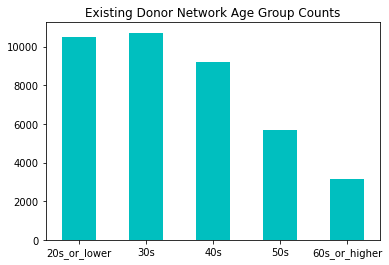

In [7]:
df1 = transform_plot_age(df1, 'Existing')

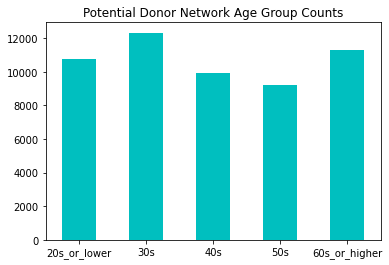

In [8]:
df2 = transform_plot_age(df2, 'Potential')

In the existing donor network there is a smaller sample size for the older age groups. They are fairly balanced for the potential donor network.

### Education Level

In [9]:
# the names will become columns after encoding
sort_order = ['edu_hs_or_lower', 'edu_associate', 'edu_bachelor', 
              'edu_master', 'edu_doctorate']

def transform_plot_education_level(df, dataset_name):
    ''' Change educational levels to bins, rename the column,
        plot the value counts, set column to categorical, and one-hot encode
    
        Parameters: df (pd.DataFrame): dataset to transform
                    dataset_name: reference for plotting
        
        Output:     bar plot of value counts
        
        Returns:    transformed dataframe
    '''
    # existing donor network
    if dataset_name == 'Existing':
        # create bins for education level
        df['education_level'] = df['education_level'].map({' Preschool': 'edu_hs_or_lower',
                                                           ' 1st-4th': 'edu_hs_or_lower',
                                                           ' 5th-6th': 'edu_hs_or_lower',
                                                           ' 7th-8th': 'edu_hs_or_lower',
                                                           ' 9th': 'edu_hs_or_lower',
                                                           ' 10th': 'edu_hs_or_lower',
                                                           ' 11th': 'edu_hs_or_lower',
                                                           ' 12th': 'edu_hs_or_lower',
                                                           ' HS-grad': 'edu_hs_or_lower',
                                                           ' Some-college': 'edu_hs_or_lower',
                                                           ' Assoc-acdm': 'edu_associate',
                                                           ' Assoc-voc': 'edu_associate',
                                                           ' Prof-school': 'edu_associate',
                                                           ' Bachelors': 'edu_bachelor',
                                                           ' Masters': 'edu_master',
                                                           ' Doctorate': 'edu_doctorate'})
    # potential donor network
    elif dataset_name == 'Potential':
        # create bins for education level
        df['education_level'] = df['education_level'].map({'High School Diploma': 'edu_hs_or_lower',
                                                           'Associate Degree': 'edu_associate',
                                                           'Bachelor\'s Degree': 'edu_bachelor',
                                                           'Master\'s Degree': 'edu_master',
                                                           'Doctorate': 'edu_doctorate'})
    # counts per education level bin as barplot
    df['education_level'].value_counts()[sort_order].plot(kind='bar', color='c')
    
    # add title, make x labels legible
    plt.title(f'{dataset_name} Donor Network Education Level')
    plt.xticks(rotation=7)
    plt.show();
    
    # change feature to a categorical column to establish desired order of bins
    df['education_level'] = pd.Categorical(df['education_level'], categories=sort_order, ordered=True)
    
    # one hot encode ordered education level bins into individual columns
    # 0 in all education level columns represents edu_hs_or_lower
    df = pd.get_dummies(df, columns=['education_level'], drop_first=True)
    
    return df

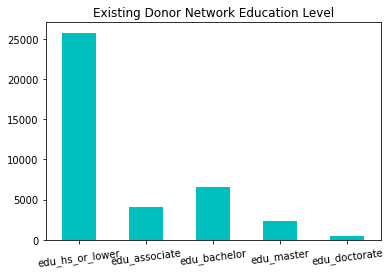

In [10]:
df1 = transform_plot_education_level(df1, 'Existing')

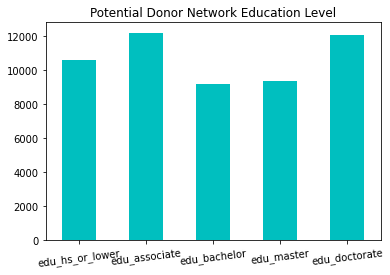

In [11]:
df2 = transform_plot_education_level(df2, 'Potential')

The vast majority of our existing donor network dataset is composed of those who have at most a high school education. This creates a situation where the algorithms will have a skewed perception on this column because there are only so many examples to learn patterns from. On the other hand, there is again a nice balance across the potential donor network dataset.  

### Marital Status

In [12]:
# the names will become columns after encoding
sort_order = ['single', 'married', 'separated', 'divorced', 'widowed']

def transform_plot_marital_status(df, dataset_name):
    ''' Change marital status to bins, rename the column,
        plot the value counts, set column to categorical, and one-hot encode
    
        Parameters: df (pd.DataFrame): dataset to transform
                    dataset_name: reference for plotting
        
        Output:     bar plot of value counts
        
        Returns:    transformed dataframe
    '''
    # existing donor network
    if dataset_name == 'Existing':
        # create bins for marital status
        df['marital_status'] = df['marital_status'].map({' Never-married': 'single',
                                                         ' Married': 'married',
                                                         ' Married-civ-spouse': 'married',
                                                         ' Married-spouse-absent': 'married',
                                                         ' Married-AF-spouse': 'married',
                                                         ' Separated': 'separated',
                                                         ' Divorced': 'divorced',
                                                         ' Widowed': 'widowed'})
    # potential donor network
    elif dataset_name == 'Potential':
        # create bins for marital status
        df['marital_status'] = df['marital_status'].map({'Single': 'single',
                                                         'Married': 'married',
                                                         'Separated': 'separated',
                                                         'Divorced': 'divorced',
                                                         'Widowed': 'widowed'})
    # counts per marital status bin as barplot
    df['marital_status'].value_counts()[sort_order].plot(kind='bar', color='c')
    
    # add title, make x labels legible
    plt.title(f'{dataset_name} Donor Network Marital Status')
    plt.xticks(rotation=0)
    plt.show();
    
    # change feature to a categorical column to establish desired order of bins
    df['marital_status'] = pd.Categorical(df['marital_status'], categories=sort_order, ordered=True)
    
    # one hot encode ordered marital status bins into individual columns
    # 0 in all marital status columns represents single
    df = pd.get_dummies(df, columns=['marital_status'], drop_first=True)
    
    return df

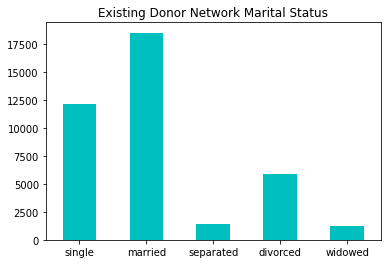

In [13]:
df1 = transform_plot_marital_status(df1, 'Existing')

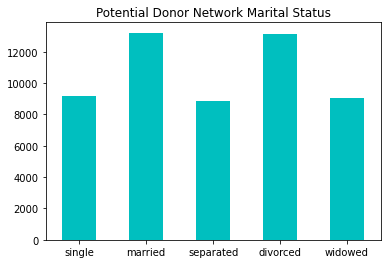

In [14]:
df2 = transform_plot_marital_status(df2, 'Potential')

We're beginning to see a trend here, as the existing donor network is made up primarily of those who are single and married. The potential donor network has numerous options for each variable.

### Gender

In [15]:
def transform_plot_gender(df, dataset_name):
    ''' Plot the value counts, change gender to binary encoding, 
        and rename the column
       
        Parameters: df (pd.DataFrame): dataset to transform
                    dataset_name: reference for plotting
        
        Output:     bar plot of value counts
        
        Returns:    transformed dataframe
    '''
    # counts per gender as barplot 
    df['gender'].value_counts().plot(kind='bar', color='c')

    # add title, make x labels legible
    plt.title(f'{dataset_name} Donor Network Gender')
    plt.xticks(rotation=0)
    plt.show();   
    
    # existing donor network
    if dataset_name == 'Existing':
        # create binary encoding for gender
        df['gender'] = df['gender'].map({' Female': 0, ' Male': 1})
        
    # potential donor network
    elif dataset_name == 'Potential':
        # create binary encoding for gender
        df['gender'] = df['gender'].map({'Female': 0, 'Male': 1})
    
    # change name to reflect shift
    # 0 in gender_male column represents female
    df.rename(columns={'gender': 'gender_male'}, inplace=True)
    
    return df

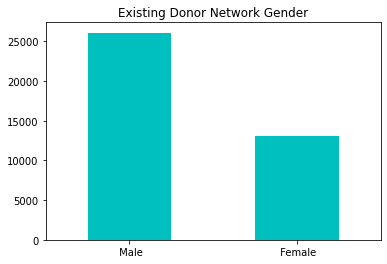

In [16]:
df1 = transform_plot_gender(df1, 'Existing')

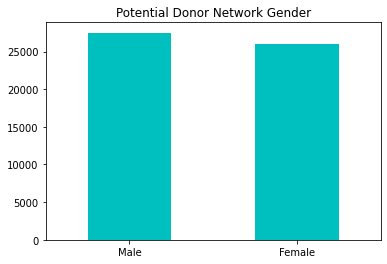

In [17]:
df2 = transform_plot_gender(df2, 'Potential')

It can be confirmed that each feature is skewed for the existing donor network. Perhaps this happened organically through word of mouth. Our previous donor acquisition approach has been primarily focused on a certain demographic grouping that stands out. Younger, at most a high school education, single or married, and male seems to be example the model will learn the most about. The danger in this situation is that it may create an artifact in the modeling where the equations are able to distinguish this kind of person extremely well, without being able to appropriately delineate amongst other kinds of people. Between this skewing inherent in the dataset in terms of representation and the fact that the demographic overlap between the two datasets is only four columns, there is a limit to the nuance even the most advanced model can pick out without simply memorizing the data.

### Salary > 50k

In [18]:
def transform_plot_income(df, dataset_name):
    ''' Change income to binary encoding, rename the column,
        and plot the value counts
       
        Parameters: df (pd.DataFrame): dataset to transform
                    dataset_name: reference for plotting
        
        Output:     bar plot of value counts
        
        Returns:    transformed dataframe
    '''
    # change name to reflect shift
    # 0 in salary_gt_50k column represents those who 
    # make less than or equal to $50,000/year
    df.rename(columns={'income': 'salary_gt_50k'}, inplace=True) 

    # existing donor network
    if dataset_name == 'Existing':
        # create binary encoding for income
        df['salary_gt_50k'] = df['salary_gt_50k'].map({'<=50K': 0, '>50K': 1})
        
        # counts per salary as barplot    
        df['salary_gt_50k'].value_counts().plot(kind='bar', color='c')
        
    # potential donor network
    elif dataset_name == 'Potential':
        # create binary encoding for income
        df['salary_gt_50k'] = (df['salary_gt_50k'] > 50000).astype(int)
 
        # sorted counts per salary as barplot
        df['salary_gt_50k'].value_counts(ascending=True).plot(kind='bar', color='c')

    # add title, make x labels legible    
    plt.title(f'{dataset_name} Donor Network Salary Greater Than 50k')
    plt.xticks(rotation=0)
    plt.show();
    
    return df

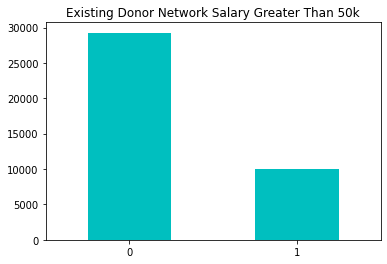

In [19]:
df1 = transform_plot_income(df1, 'Existing')

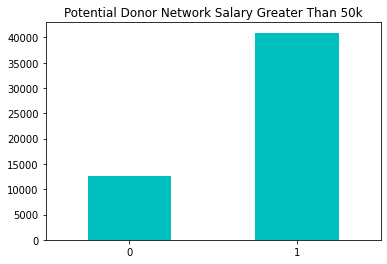

In [20]:
df2 = transform_plot_income(df2, 'Potential')

Due to the inverse balance between these two datasets (where, in the existing donor network dataset we primarily have those who make $50,000/year or less and in the potential donor network dataset we have the opposite), a level of error can be expected in our later modeling efforts. But, thankfully, we have more opportunity than we do scarcity in the potential donor network. 

### View Encoding

We can now observe the refined datasets, where each feature and the target may be represented as a binary column through encoding. There was, of course, several off-screen verifications of the data transformation pipeline to ensure that everything happened according to the code as intended. These cell blocks were removed for brevity.

In [21]:
df1.head()

,gender_male,salary_gt_50k,age_group_30s,age_group_40s,age_group_50s,age_group_60s_or_higher,education_level_edu_associate,education_level_edu_bachelor,education_level_edu_master,education_level_edu_doctorate,marital_status_married,marital_status_separated,marital_status_divorced,marital_status_widowed
0,1,0,1,0,0,0,0,1,0,0,0,0,0,0
1,1,0,0,0,1,0,0,1,0,0,1,0,0,0
2,1,0,1,0,0,0,0,0,0,0,0,0,1,0
3,1,0,0,0,1,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,1,0,0,1,0,0,0


In [22]:
df2.head()

,gender_male,salary_gt_50k,age_group_30s,age_group_40s,age_group_50s,age_group_60s_or_higher,education_level_edu_associate,education_level_edu_bachelor,education_level_edu_master,education_level_edu_doctorate,marital_status_married,marital_status_separated,marital_status_divorced,marital_status_widowed
0,0,1,0,0,0,0,1,0,0,0,1,0,0,0
1,1,1,0,0,0,0,0,0,0,1,0,0,0,1
2,0,1,0,0,0,0,1,0,0,0,0,0,0,0
3,1,1,0,0,0,0,0,1,0,0,0,0,1,0
4,0,0,0,0,0,0,0,1,0,0,0,1,0,0


<a id='supervised'></a>
## III. Supervised Predictive Modeling

Now that both datasets are ready for analysis, we will begin by separating the feature columns into `X` and the target variable into `y`. The existing donor network will be split 80/20, to create a validation set to assess the Logistic Regression model before it is tested "in the wild". 

### Training & Validation

In [23]:
# keep all existing donor network columns for 
# training and validation except target
X = df1[['gender_male', 'age_group_30s', 'age_group_40s', 
         'age_group_50s', 'age_group_60s_or_higher',
         'education_level_edu_associate', 'education_level_edu_bachelor',
         'education_level_edu_master', 'education_level_edu_doctorate',
         'marital_status_married', 'marital_status_separated',
         'marital_status_divorced', 'marital_status_widowed']]

# separate dependent target variable
y = df1['salary_gt_50k']

In [24]:
# keep 80% of the existing donor network for training, 
# 20% will be separated validation
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=0)

print("Training set has {} samples.".format(X_train.shape[0]))
print("Validation set has {} samples.".format(X_valid.shape[0]))

Training set has 31392 samples.
Validation set has 7848 samples.


Here, the model is instantiated, fit on the training data, and checked against the validation set.

In [25]:
# instantiate the model given an equal weight to both classes
# default penalty, C, and solver were found to be optimal during tuning
lr_model = LogisticRegression(penalty='l2', C=1.0, class_weight='balanced', 
                              random_state=0, solver='lbfgs')

# fit the model to the training data
lr_model.fit(X_train, y_train)

# make predictions using the fit model on the validation data
validation_results = lr_model.predict(X_valid)

In [26]:
# how many were correctly labeled
print(f'Validation Accuracy: {accuracy_score(y_valid, validation_results)*100:.2f}%')

# fbeta balances the harmonic mean of precision and recall
# a beta < 1 weighs precision more heavily; getting
# true positives as correct as possible for potential donors
print(f'Validation Fbeta (0.5): {fbeta_score(y_valid, validation_results, beta=0.5)*100:.2f}%')

Validation Accuracy: 72.52%
Validation Fbeta (0.5): 51.63%


Given the circumstance of the skewed demographics previously enumerated, this a solid result after digging into tuning the model. Many of the default parameters stood true during the optimization process. The key here is that the fbeta score is tilted toward precision, meaning that we really want to focus on getting the people that we think will donate correct. There are more advanced algorithms that could be applied at this step, but I was concerned that 1) they may simply memorize the small feature list of the dataset and 2) the explainability and interpretability of the model would fall away. The staying power of regression is its sheer transparency. 

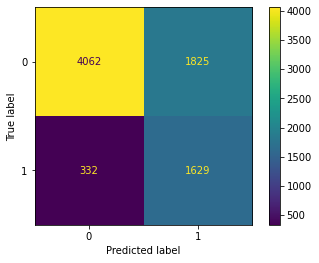

In [27]:
# true negative, false positive
# false negative, true positive
valid_cm = confusion_matrix(y_valid, validation_results)
ConfusionMatrixDisplay(valid_cm).plot();

A confusion matrix is a wonderful tool. It is worth digging into a little bit. In the top left, we see that 4,062 data points in the validation set were predicted to be non-donors, and were in fact non-donors. This is our true negative rate.

Conversely, on the bottom right, we have those people who were predicted to be donors and are. The number totalled 1,629 for this true positive, and this is the focus for our precision that was previously mentioned.

The tricky parts are the other components. In the bottom left, we have the people who were predicted to not be donors, but were in fact according to our existing donor network dataset. What this means is that we missed 332 people here to the false negative.

Finally, at the top right, we have 1,825 people that we predicted to be donors, but were not. This is a false positive, and is the risk we run with the limitations of the data. The training set was small (~30,000 rows), it was skewed towards a certain demographic, and there a limited number of features. Given these constraints, this result is acceptable. 

In [28]:
# how the logistic regression model weighs each
# column; the coefficients of the hidden columns are implied
pd.DataFrame(data=lr_model.coef_.T, index=X.columns, columns=['coefficients'])

,coefficients
gender_male,0.468580
age_group_30s,1.057119
age_group_40s,1.378633
age_group_50s,1.441261
age_group_60s_or_higher,0.850360
education_level_edu_associate,1.126758
education_level_edu_bachelor,1.500777
education_level_edu_master,2.008976
education_level_edu_doctorate,2.656743
marital_status_married,2.235065


Where some algorithms are difficult to look into in order to understand how decisions are made, regression is amenable. `gender_male` being less than 0.5 shows a bias towards females for donors. The increasing coefficients from `age_group_30s` up to `age_group_50s` gives us a reasonable notion that we're looking for a more "mature" person. Again, as education level gets higher, so does the weight coefficient as connected to salary/whether or not the person is a donor. Lastly, for relationship status, we see the married population stand out. 

### Testing

Below, a similar process is repeated for the potential donor network dataset. The target variable `y` is separated for prediction. This holdout dataset will not be split, though, and is instead used in its entirety.

In [29]:
# keep all potential donor network columns for 
# testing except target
X_test = df2[['gender_male', 'age_group_30s', 'age_group_40s', 
              'age_group_50s', 'age_group_60s_or_higher',
              'education_level_edu_associate', 'education_level_edu_bachelor',
              'education_level_edu_master', 'education_level_edu_doctorate',
              'marital_status_married', 'marital_status_separated',
              'marital_status_divorced', 'marital_status_widowed']]

# separate dependent target variable
y_test = df2['salary_gt_50k']

print("Test set has {} samples.".format(X_test.shape[0]))

Test set has 53503 samples.


A new logistic regression model is not trained here- instead, the previously fit model is given the unseen information blind and without any help. It must seek to adequately locate donors without any aid, based on the patterns it has previously seen.

In [30]:
# data is not split; all of it will be used for testing
# use the previously fit model to predict on an unseen dataset
test_results = lr_model.predict(X_test)

In [31]:
# how many were correctly labeled
print(f'Test Accuracy: {accuracy_score(y_test, test_results)*100:.2f}%')

# fbeta balances the harmonic mean of precision and recall
# a beta < 1 weighs precision more heavily; getting
# true positives as correct as possible for potential donors
print(f'Test Fbeta (0.5): {fbeta_score(y_test, test_results, beta=0.5)*100:.2f}%')

Test Accuracy: 47.61%
Test Fbeta (0.5): 67.31%


As expected, our accuracy drops due to the variable imbalance previously espoused. To the delight of our charity, though, the fbeta score weighted toward precision and true positives actually increased. This is our key performance metric for this process, and the model shows its worth.

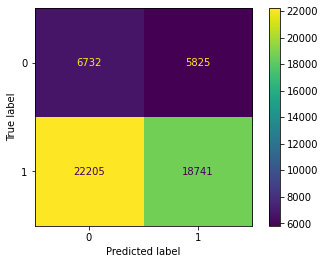

In [32]:
# true negative, false positive
# false negative, true positive
test_cm = confusion_matrix(y_test, test_results)
ConfusionMatrixDisplay(test_cm).plot();

Decisions are made by the model based on a class weight threshold at the determination for labeling. After off-screen testing, this model was given `balanced` weights so that is favors neither class as being more or less important. This confusion matrix shows a drastic increase on false negatives, meaning that there are donors that the model was not confident enough of and marked them off the short-list. Again, this is to be expected given the imbalance in the existing donor network when compared to the overall composition of the potential donor network. The focus here is that, for those that the model thinks will donate, the majority (~75%) are likely to.

<a id='unsupervised'></a>
## IV. Unsupervised Clustering Segmentation

We can now transition to Principal Component Analysis and KMeans Clustering for our second model. Here, we're going to drop the majority of the existing donor network. What this means for our purposes is that we are retaining those that have a salary that is greater than $50,000/year, marking them out as those who are previous and/or current donors. The rest can be considered those who have churned as donors in the past and we were unable to retain them, or those who simply did not donate to our charity. This will give us a concentrated set of examples, from which we can pick out and _decompose_ the essential combinations of our feature variables that explain our data.

### Principal Component Analysis

In [33]:
# create a copy of the refined existing donor dataset
# where the income level is known to be greater than
# $50,000/year representing the people in the network
# that we know have donated before
X_existing_donors = df1[df1['salary_gt_50k'] == 1].copy(deep=True)

In [34]:
# drop the people representing those who have been
# contacted previously and are considered known non-donors
X_existing_donors.drop('salary_gt_50k', axis=1, inplace=True)

In [35]:
# Principal Component Analysis decomposer
pca = PCA()

# fit the decomposer to the donor data
X_pca = pca.fit_transform(X_existing_donors)

In [36]:
# how much data each of the principal components represents
pd.DataFrame(pca.explained_variance_ratio_*100, columns=['percentage_of_data'])

,percentage_of_data
0,21.304086
1,16.767106
2,14.374458
3,12.772915
4,8.988635
5,7.266438
6,6.689557
7,5.177391
8,2.277832
9,2.168336


Without being passed an argument which defines a specific number of components, PCA will create a baseline that explains 100% of the data. The beauty of this tool is that it can be used to determine a sweet spot- meaning, how few principal components explain how much of the data? After the eighth component, explainability drops from 5% of the data to 2% per component, marking our cutoff point. We will be able to retain eight components to explain approximately 90% of the data.

In [37]:
# optimize the number of overall components
pca = PCA(n_components=8)

# retrain decomposer on new component size
X_pca = pca.fit_transform(X)

In [38]:
# 90% of the data is represented in 8 components
sum(pca.explained_variance_ratio_)

0.898270953815741

In [39]:
# show the column weights for the top component representing 21% of the data
pd.DataFrame(data=pca.components_[0], index=X.columns, columns=['pca_coefficients'])

,pca_coefficients
gender_male,-0.595358
age_group_30s,-0.022696
age_group_40s,-0.065520
age_group_50s,-0.062232
age_group_60s_or_higher,-0.017053
education_level_edu_associate,-0.010662
education_level_edu_bachelor,-0.042872
education_level_edu_master,-0.015695
education_level_edu_doctorate,-0.009544
marital_status_married,-0.731178


Here is an example of what the principal component coefficients look like. This specific example references the top component, explaining about 21% of the variation in the data. They look similar to the Logistic Regression model's coefficients, and can be interpreted at the most basic level as weights associated with each feature.

### KMeans Clustering Fitting Existing Donor Network

Using the decomposition above, the KMeans clustering model will be selected. This algorithm will group the data using randomly generated centroids and try to find data points that are closely related to one another. In order to find the "right" number of centroids to move forward with, several KMeans models will be generated ranging from 2 to 11 clusters. This clustering segmentation can be thought of as discovering and delineating different "kinds" of donors that have similar demographics to each other.

In [40]:
# helper code from Udacity Clustering course
def score_clusters(start, stop, step, data):
    ''' Generate a span of KMeans models to 
        evaluate the best score based on the pca
    '''
    # track scores
    scores = []
    # over a number of different cluster counts
    centers = list(range(start, stop, step))
    
    # run k-means clustering on the data for each n_cluster value
    for center in centers:
        # create a KMeans model
        kmeans = KMeans(n_clusters=center)
        # train on the principal components
        model = kmeans.fit(data)
        # compute the average within-cluster distances
        score = np.abs(model.score(data))
        # add it to the tracker
        scores.append(score)
        
        # show progress
        print('Clusters: {}, Score: {}'.format(center, score))
        
        
    return centers, scores

In [41]:
# this function has been commented out to reduce re-run time
# it shows kmeans models with 2-11 clusters and their relative
# scores as they are instantiated for evaluation
#centers, scores = score_clusters(2, 12, 1, X_train)

In [42]:
# number of centroid clusters per model
centers = list(range(2, 12, 1))

# manually compile cluster scores from previously
# commented out long-running function
scores = [38599, 34384, 30533, 27919, 26080,
          23991, 21438, 19930, 19501, 18502]

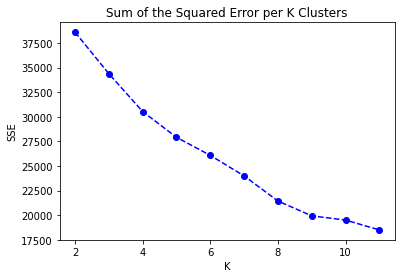

In [43]:
# helper code from Udacity Clustering course
# generate a line plot for each center, score pair
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.title('Sum of the Squared Error per K Clusters');
plt.xlabel('K');
plt.ylabel('SSE');

Just like the PCA split, choosing the number of centroids is a bit of an art and depends on the data. Here, the elbow method was chosen in combination with numerical analysis. What that means is, at the point where there stops being such a significant drop in the sum of squared error (based on the decline of the line and the decrease in the absolute number), we stop. Here, 5 centroid clusters was selected as the model to move forward with.

In [44]:
# instantiate KMeans model; elbow method was used 
# to pick the most impactful centroid count; 
kmeans_model = KMeans(n_clusters=5, random_state=0)

# fit the model to the decomposed data
kmeans_model.fit(X_pca)

KMeans(n_clusters=5, random_state=0)

In [45]:
# score the final model and show the cluster size
kmeans_score = np.abs(kmeans_model.score(X_pca))
print('Clusters: {}, Score: {}'.format(5, kmeans_score))

Clusters: 5, Score: 27905.56702589206


In [46]:
# save the cluster label predictions for the
# decomposed data for segmentation analysis
kmeans_labels = kmeans_model.predict(X_pca)

Above, the fit KMeans Clustering model is used to predict labels for the existing donor network and these labels are saved for later.

### KMeans Clustering Labeling Potential Donor Network

It is important that, at this stage where we're going to assess the potential donor network, a new PCA decomposer is not fit. The previous one, exposed to the existing donor network dataset and retained, is used to break down the unseen data.

In [47]:
# use the previously constructed decomposer
# to break down and analyze the 
# potential donor network dataset
X_potential_pca = pca.transform(X_test)

In likewise fashion, it is the previously fit KMeans model that is used to make predictions on the unseen data. The idea is that different groups of donors have been found in those known to be donors, and we're looking for people we've never seen before who "look like" our highest contributing cluster based on their demographics.

In [48]:
# use the previously constructed kmeans clustering
# model to make label predictions on the newly
# decomposed data
kmeans_potential_labels = kmeans_model.predict(X_potential_pca)

In [49]:
# move the existing and potential donor network 
# labels to pandas dataframe objects for assessment
existing_labels_df = pd.DataFrame(kmeans_labels)
potential_labels_df = pd.DataFrame(kmeans_potential_labels)

In [50]:
# new, empty dataframe
comparison = pd.DataFrame()

# centroid numbers (1-5)
K = list(range(1, 6))

# raw count of centroid identity for existing donors
existing_counts = existing_labels_df[0].value_counts(sort=False)
existing_percentages = []

# raw count of centroid identity for potential donors
potential_counts = potential_labels_df[0].value_counts(sort=False)
potential_percentages = []
difference = []
percentage_ratio = []

# calculate key comparison metrics and compile in lists
for i in range(len(existing_counts)):
    existing_percentages.append(round((existing_counts[i]/existing_labels_df.shape[0])*100, 2))
    potential_percentages.append(round((potential_counts[i]/potential_labels_df.shape[0])*100, 2))
    difference.append(np.subtract(existing_percentages[i], potential_percentages[i]))
    percentage_ratio.append(round(np.divide(potential_percentages[i], existing_percentages[i]), 2))

# load metric lists to empty dataframe for analysis below
comparison['K Clusters'] = K
comparison['Existing Counts'] = existing_counts
comparison['Existing Percentages'] = existing_percentages
comparison['Potential Counts'] = potential_counts
comparison['Potential Percentages'] = potential_percentages
comparison['Difference'] = difference
comparison['Percentage Ratio'] = percentage_ratio

print('Existing Donor Network and Potential Donor Network')
print('Existing: {:,}     Potential: {:,}'.format(existing_labels_df.shape[0], 
                                                  potential_labels_df.shape[0]))
comparison

Existing Donor Network and Potential Donor Network
Existing: 39,240     Potential: 53,503


,K Clusters,Existing Counts,Existing Percentages,Potential Counts,Potential Percentages,Difference,Percentage Ratio
0,1,5433,13.85,2574,4.81,9.04,0.35
1,2,9859,25.12,20690,38.67,-13.55,1.54
2,3,5492,14.00,3053,5.71,8.29,0.41
3,4,7237,18.44,6478,12.11,6.33,0.66
4,5,11219,28.59,20708,38.70,-10.11,1.35


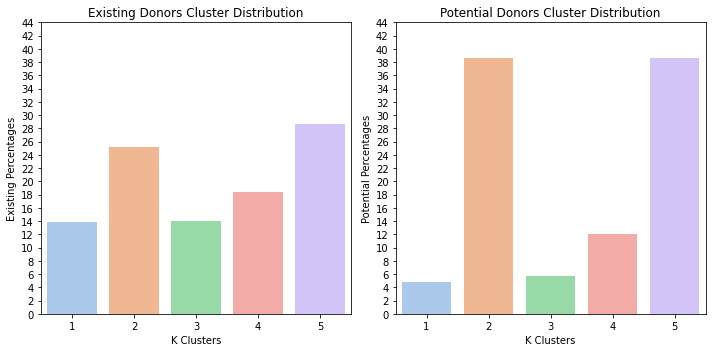

In [51]:
# plot the above comparison dataframe
# make the combined plots span the width of the notebook
plt.figure(figsize=(10,5))

# first plot (one row, two columns, first index)
ax1 = plt.subplot(1, 2, 1)
# clusters against value_counts for existing donor network data
ax1.set_title('Existing Donors Cluster Distribution')
ax1.set_ylim(0, 44)
ax1.set_yticks(range(0, 45, 2))
# view the distribution
sb.barplot(x=comparison['K Clusters'], y=comparison['Existing Percentages'], palette='pastel', ax=ax1)

# second plot (one row, two columns, second index)
ax2 = plt.subplot(1, 2, 2)
# clusters against value_counts for potential donor network data
ax2.set_title('Potential Donors Cluster Distribution')
ax2.set_ylim(0, 44)
ax2.set_yticks(range(0, 45, 2))
# view the distribution
sb.barplot(x=comparison['K Clusters'], y=comparison['Potential Percentages'], palette='pastel', ax=ax2)

# make sure both plots are visible without any runover of their information
plt.tight_layout()
# show both plots togethered without any extra chart junk
plt.show();

We have found, in both the numerical table and the two graphs above, that there are in fact specific groups of donors in the existing donor network cluster distribution. Specifically, we're going to take a closer look at cluster five as the top contributors, and cluster one as the bottom contributors.

Notice how there is a large portion of the potential donors that is considered a part of cluster five. That's great! That means there is a significant pool of people that are very similar to the people we know are strong supporters of our charity. 

To draw clarity to this, we can see the opposite effect by looking at cluster one. This is the smallest percentage of our donors, and it also makes up the tiniest fraction of the potential donors. These are very clear signs that we should not spend our time and energy contacting these people given the urgency of the situation we find ourselves in, as we are nearing an important deadline at the end of the fiscal year and the probability that there will be a return on that investment is low when compared to other prospects.

In [52]:
# existing donor network
# total count per column for the top cluster; it is the
# sum of those present as True/1 for the column, where
# a lower count for a grouping implies the baseline category
X.groupby(kmeans_labels == 4).sum().loc[True]

gender_male                         0.0
age_group_30s                    2581.0
age_group_40s                    2229.0
age_group_50s                    1295.0
age_group_60s_or_higher           898.0
education_level_edu_associate    1142.0
education_level_edu_bachelor     1689.0
education_level_edu_master        609.0
education_level_edu_doctorate      82.0
marital_status_married            497.0
marital_status_separated          837.0
marital_status_divorced          3498.0
marital_status_widowed           1021.0
Name: True, dtype: float64

Immediately above is a breakdown of counts for people in the existing donor network dataset that have been labeled as a part of our top contributing cluster, cluster number five. They are decidedly female, according to our binary gender feature. There is a good spread across age, but thirties seems to be the age group that stands out. Education is present, centered around the Bachelor degree. The number of divorcees that are present is striking. According to the clustering algorithm, our best contributors are those that have been recorded as female, in there thirties, who are divorced. There is definitely some breadth to this cluster, though.

In [53]:
# existing donor network; bottom cluster
X.groupby(kmeans_labels == 0).sum().loc[True]

gender_male                      4790.0
age_group_30s                       0.0
age_group_40s                    5433.0
age_group_50s                       0.0
age_group_60s_or_higher             0.0
education_level_edu_associate     692.0
education_level_edu_bachelor     1241.0
education_level_edu_master        489.0
education_level_edu_doctorate     125.0
marital_status_married           5305.0
marital_status_separated            0.0
marital_status_divorced             0.0
marital_status_widowed              0.0
Name: True, dtype: float64

Immediately above is the complement; a breakdown of counts for people in the existing donor network dataset that have been labeled as part of our bottom contributing cluster, cluster number one. The sheer number of males is significant. It is composed primarily of those in their fourties. Many of them are married. It will be important to de-prioritize contacting married men in their forties for our immediate outreach efforts, as this cluster is fairly decisive.

<a id='intersecting'></a>
## V. Intersecting Prediction & Segmentation

In [54]:
# actual count
df2.query('@test_results == 1 and @kmeans_potential_labels == 4').shape[0]

5642

In [55]:
# potential donor networking ensemble analysis
# intersection between top cluster and predicted as donor based on salary
df2.query('@test_results == 1 and @kmeans_potential_labels == 4').sum()

gender_male                         0
salary_gt_50k                    4254
age_group_30s                    1296
age_group_40s                    1162
age_group_50s                    1394
age_group_60s_or_higher          1062
education_level_edu_associate       0
education_level_edu_bachelor      211
education_level_edu_master       1369
education_level_edu_doctorate    4062
marital_status_married            728
marital_status_separated         1081
marital_status_divorced          1676
marital_status_widowed           1219
dtype: int64

The KMeans Clustering algorithm was not exposed to the `salary_gt_50k` target variable, but it has been included here as a point of reference. Out of 5642 potential donors that have been labeled as both a donor by the Logistic Regression model and as in the top contributing cluster (cluster five) by the KMeans Clustering algorithm, 4254 are actually marked as our target of having a salary greater than $50,000/year. This aligns and reinforces our previous confidence in the predictive modeling returning with a precision of approximately 75%.

In [56]:
# intersection between bottom cluster and predicted as non-donor based on salary
df2.query('@test_results == 0 and @kmeans_potential_labels == 0').sum()

gender_male                      156
salary_gt_50k                    111
age_group_30s                      0
age_group_40s                    156
age_group_50s                      0
age_group_60s_or_higher            0
education_level_edu_associate      0
education_level_edu_bachelor     156
education_level_edu_master         0
education_level_edu_doctorate      0
marital_status_married             0
marital_status_separated           0
marital_status_divorced            0
marital_status_widowed             0
dtype: int64

Out of curiousity, who should we not contact for donations? According to those predicted to be a non-donor and labeled as a bottom contributor, it would be those who are male, in their forties, with a Bachelor's degree. This aligns fairly well with our previous insight. Perhaps our cause isn't necessarily relavent to their lives at this moment, and they would be better off left to themselves for the purposes of donor acquisition for our charity at this time.

### Final Deliverable

An essential contact list of high potential donors will be the most helpful insight that our team can access at this time. This short-list of identification numbers for who can be reached out to for help and support can be broken down per team member and distributed accordingly, ensuring that everyone is able to focus on them as the highest priority.

In [57]:
# list of those who were predicted to be a donor based on salary
# and those who were in the top cluster
contact_list = original_potential_donors.query('@test_results == 1 and \
                                 @kmeans_potential_labels == 4')['Customer ID']

In [58]:
# new dataframe based on previous slicing
contact_list = pd.DataFrame(data=contact_list)
contact_list.head()

,Customer ID
8,30476
25,62346
31,82780
36,70594
37,32721


In [59]:
# filtered and concentrated potential donor network
print(f'Contact list is the top {(contact_list.shape[0] / df2.shape[0])*100:.2f}% potential donors')
print(f'Number of contacts: {contact_list.shape[0]}')

Contact list is the top 10.55% potential donors
Number of contacts: 5642


In [60]:
# move to external csv file for transfer of short-list
contact_list.to_csv('contact_list.csv', index=False)

Those that we _know_ are non-donors from the actual target variables of the testing dataset are included in this list, because in reality the short-list would not actually know the end-state of the potential donors. This is information that the KMeans clustering algorithm did not and would not actually have access to, and during real-world inference we would not have that information either.

<a id='final'></a>
## VI. Final Thoughts

Our charity is nearing dissolution. The good news is that we have a large pool of potential donors to contact. At the beginning of our project there were too many to simply brute force our way through. Picking them seemingly at random definitely had a high chance of failure.

There are in fact some potential donors who are more likely to donate than not, and they can be recognized with a strong confidence. Even given limited information and time, now our charity has a short-list of contacts that represent the most likely donor candidates that has been cross-verified using an ensemble of both supervised and unsupervised learning.

This project showcases the serious capability of machine learning technologies specifically and data science methodologies in general to gain meaningful insight into otherwise complicated and terse data. It stands to show that with the proper tools, organizations are able to extract critical directives for future projects and initiatives. It represents the importance of privacy- how data is collected, stored, transmitted, and communicated. It also represents the importance of ethics- how data is used, what the purpose is, and how transparent the information gathering and implementation is in terms of the purpose it will be used for. It further represents the importance of safety- how will the actors involved, the states that the actors are in, and the geo-political environments therewith be affected by the implicit bias in the developers, the data used, the incentives given, the collection terms and methods, and the use cases that the insights gleamed are applied to. This technology has implications across these and many more sensitive subjects and deserves further study.

<a id='sources'></a>
## VII. Sources

This project originated from and was inspired by Udacity's [Introduction to Machine Learning with PyTorch](https://www.udacity.com/course/intro-to-machine-learning-nanodegree--nd229) Nanodegree. Within each certificate program, theory is demonstrated through conceptual explanations in written language, programmatic exercises to implement said concepts in code, pseudo-code interpretations bridging spoken human language and algorithms, and pure mathematical notation. Skills and abilities are exemplified in projects that are submitted and graded against an established rubric.

The existing donor network dataset was sourced from the same Udacity Nanodegree. It is a processed version of a dataset from the [UCI Machine Learning Repostory](https://archive.ics.uci.edu/ml/datasets/Census+Income). 

The potential donor network dataset was sourced from [Kaggle](https://www.kaggle.com/datasets/ravalsmit/customer-segmentation-data?resource=download)

Innumerable references were made to Google's large language model that is embedded in their search engine, [Gemini](https://blog.google/products/search/generative-ai-google-search-may-2024/), to confirm syntax and to see implementation examples of random code snippets.

Endless combing through documentation was done to explore parameter defaults and confirm code implementation: [pandas](https://pandas.pydata.org/docs/user_guide/index.html), [scikit-learn](https://scikit-learn.org/stable/user_guide.html)